# Airline Passenger Satisfaction — Analysis Notebook

In [1]:
# Section 1: Setup & Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Plotting style
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("Set2")

DATA_DIR = Path("data")
train = pd.read_csv(DATA_DIR / "train.csv")
test = pd.read_csv(DATA_DIR / "test.csv")

# Drop unused columns
drop_cols = ["Unnamed: 0", "id"]
train = train.drop(columns=drop_cols, errors="ignore")
test = test.drop(columns=drop_cols, errors="ignore")

display(train.head())

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


## Section 2: Data Quality Checks & Cleaning
- Inspect schema and missing values
- Handle the small amount of missing Arrival Delay in Minutes rows
- Assert expected row counts after cleaning

In [2]:
# Info & NA overview
train_info = train.info()
na_counts = train.isnull().sum().sort_values(ascending=False)
display(na_counts.head(10))

# Drop rows with missing Arrival Delay in Minutes (very few)
initial_rows = len(train)
train = train.dropna(subset=["Arrival Delay in Minutes"])
cleaned_rows = len(train)

assert cleaned_rows <= initial_rows, "Row count should not increase after cleaning."
print(f"Rows before: {initial_rows}, after: {cleaned_rows} (dropped {initial_rows - cleaned_rows})")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103904 non-null  object 
 1   Customer Type                      103904 non-null  object 
 2   Age                                103904 non-null  int64  
 3   Type of Travel                     103904 non-null  object 
 4   Class                              103904 non-null  object 
 5   Flight Distance                    103904 non-null  int64  
 6   Inflight wifi service              103904 non-null  int64  
 7   Departure/Arrival time convenient  103904 non-null  int64  
 8   Ease of Online booking             103904 non-null  int64  
 9   Gate location                      103904 non-null  int64  
 10  Food and drink                     103904 non-null  int64  
 11  Online boarding                    1039

Arrival Delay in Minutes             310
Customer Type                          0
Gender                                 0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Age                                    0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Gate location                          0
dtype: int64

Rows before: 103904, after: 103594 (dropped 310)


## Section 3: Categorical Encoding
Create a mapped numeric version for correlations and simple models.

In [3]:
mappings = {
    "Gender": {"Male": 1, "Female": 0},
    "Customer Type": {"Loyal Customer": 1, "disloyal Customer": 0},
    "Type of Travel": {"Business travel": 1, "Personal Travel": 0},
    "Class": {"Business": 2, "Eco Plus": 1, "Eco": 0},
    "satisfaction": {"satisfied": 1, "neutral or dissatisfied": 0},
}

train_mapped = train.copy()
for col, mapping in mappings.items():
    if col in train_mapped.columns:
        train_mapped[col] = train_mapped[col].map(mapping)

train_mapped.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,1,1,13,0,1,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,0
1,1,0,25,1,2,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,0
2,0,1,26,1,2,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,1
3,0,1,25,1,2,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,0
4,1,1,61,1,2,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,1


## Section 4: Exploratory Visuals — Distribution & Balance
- Target distribution
- Gender balance
- Class distribution

C:\Users\Deniz\AppData\Local\Temp\ipykernel_30500\3239071192.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend().remove()
C:\Users\Deniz\AppData\Local\Temp\ipykernel_30500\3239071192.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[2].legend(title="Class")


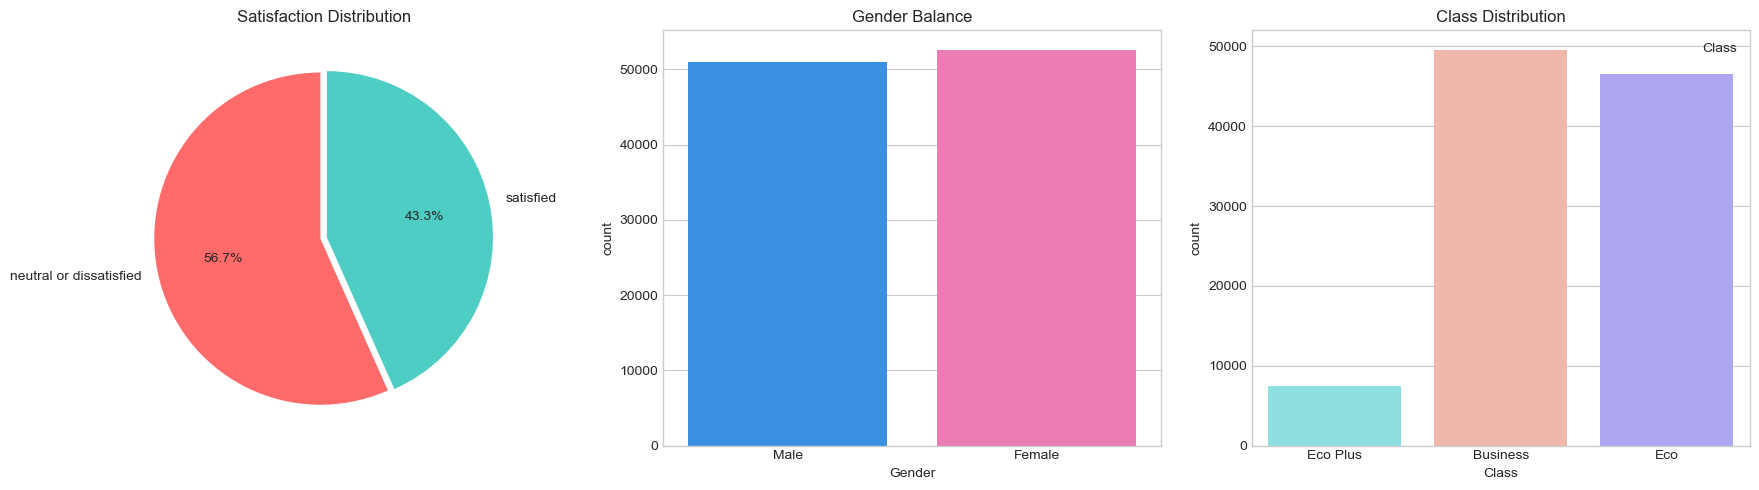

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Satisfaction distribution
sat_counts = train["satisfaction"].value_counts()
axes[0].pie(sat_counts, labels=sat_counts.index, autopct="%1.1f%%", startangle=90,
            colors=["#ff6b6b", "#4ecdc4"], explode=(0.02, 0.02))
axes[0].set_title("Satisfaction Distribution")

# Gender balance
sns.countplot(data=train, x="Gender", hue="Gender", ax=axes[1],
              palette={"Female": "hotpink", "Male": "dodgerblue"})
axes[1].set_title("Gender Balance")
axes[1].legend().remove()

# Class distribution
sns.countplot(data=train, x="Class", hue="Class", ax=axes[2],
              palette={"Eco": "#a29bfe", "Eco Plus": "#81ecec", "Business": "#fab1a0"})
axes[2].set_title("Class Distribution")
axes[2].legend(title="Class")

plt.tight_layout()
plt.show()

## Section 5: Correlation & Feature Relationships
Compute numeric correlations on the mapped data and visualize.

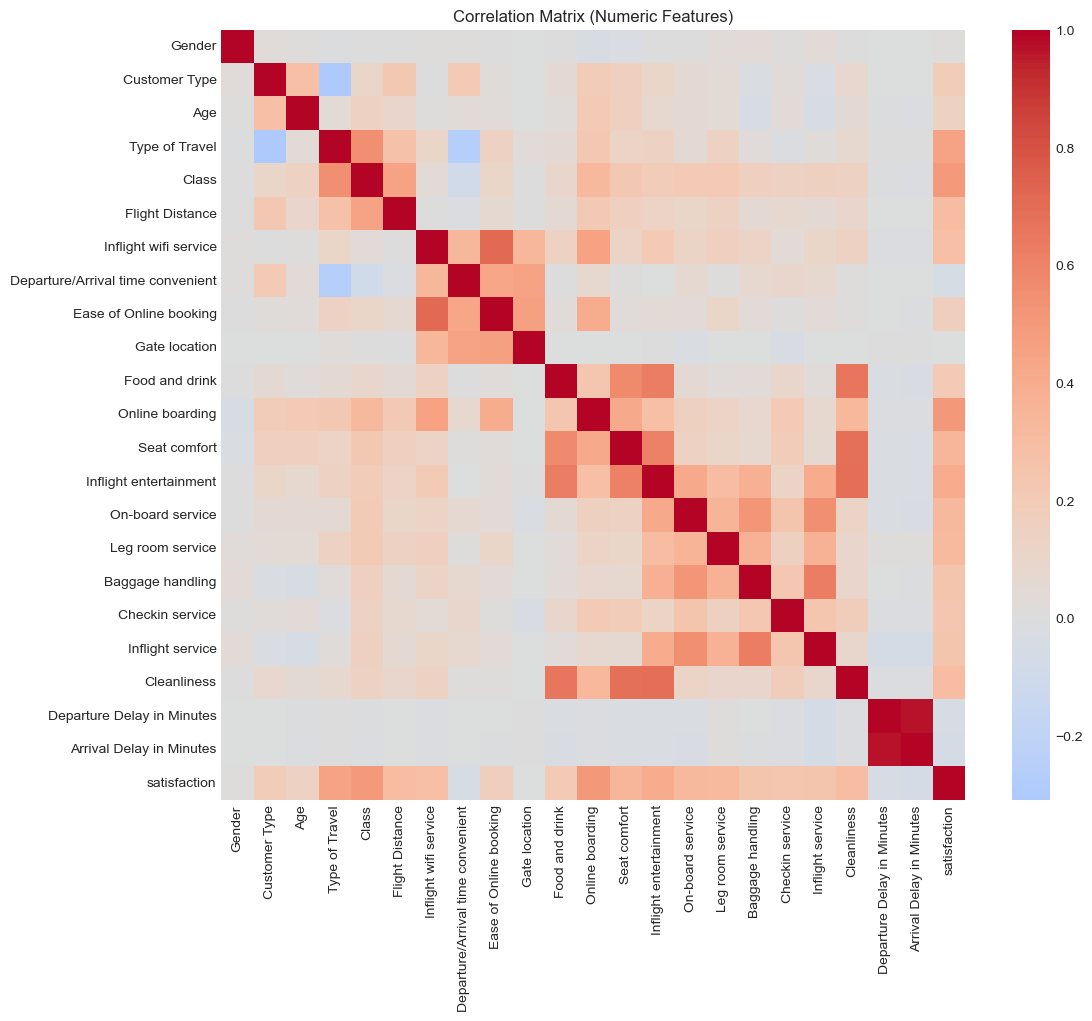

Top absolute correlations with satisfaction:
Online boarding           0.503
Class                     0.495
Type of Travel            0.449
Inflight entertainment    0.398
Seat comfort              0.349
On-board service          0.322
Leg room service          0.313
Cleanliness               0.305
Flight Distance           0.299
Inflight wifi service     0.284
Name: satisfaction, dtype: float64


In [5]:
corr_matrix = train_mapped.select_dtypes(include=["number"]).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=False) # Looks better without annotations IMO
plt.title("Correlation Matrix (Numeric Features)")
plt.show()

# Annotate strongest absolute correlations with satisfaction
satisfaction_corr = corr_matrix["satisfaction"].drop("satisfaction").sort_values(key=np.abs, ascending=False)
print("Top absolute correlations with satisfaction:")
print(satisfaction_corr.head(10).round(3))

## Section 6: Satisfaction Drivers — Service Ratings
Compare mean service scores between satisfied vs. dissatisfied passengers.

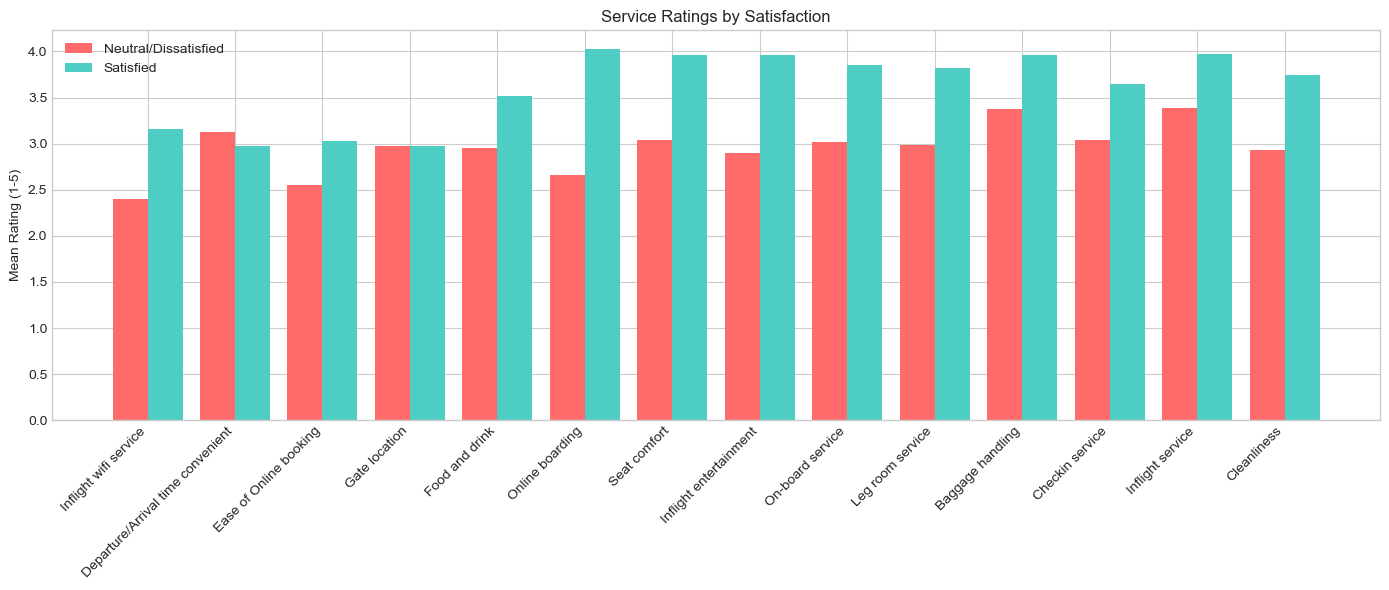

Service rating differences (Satisfied - Neutral/Dissatisfied):
Online boarding                      1.37
Inflight entertainment               1.07
Seat comfort                         0.93
On-board service                     0.84
Leg room service                     0.83
Cleanliness                          0.81
Inflight wifi service                0.76
Checkin service                      0.60
Baggage handling                     0.59
Inflight service                     0.58
Food and drink                       0.56
Ease of Online booking               0.48
Gate location                        0.00
Departure/Arrival time convenient   -0.16
dtype: float64


In [6]:
service_cols = [
    "Inflight wifi service", "Departure/Arrival time convenient", "Ease of Online booking",
    "Gate location", "Food and drink", "Online boarding", "Seat comfort",
    "Inflight entertainment", "On-board service", "Leg room service",
    "Baggage handling", "Checkin service", "Inflight service", "Cleanliness",
]

service_means = train.groupby("satisfaction")[service_cols].mean()

fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(service_cols))
width = 0.4

ax.bar(x - width/2, service_means.loc["neutral or dissatisfied"], width, label="Neutral/Dissatisfied", color="#ff6b6b")
ax.bar(x + width/2, service_means.loc["satisfied"], width, label="Satisfied", color="#4ecdc4")
ax.set_xticks(x)
ax.set_xticklabels(service_cols, rotation=45, ha="right")
ax.set_ylabel("Mean Rating (1-5)")
ax.set_title("Service Ratings by Satisfaction")
ax.legend()
plt.tight_layout()
plt.show()

diff = (service_means.loc["satisfied"] - service_means.loc["neutral or dissatisfied"]).sort_values(ascending=False)
print("Service rating differences (Satisfied - Neutral/Dissatisfied):")
print(diff.round(2))

## Section 7: Satisfaction by Segment (Class, Travel Type, Customer Type)
Stacked bars to show satisfaction composition per segment.

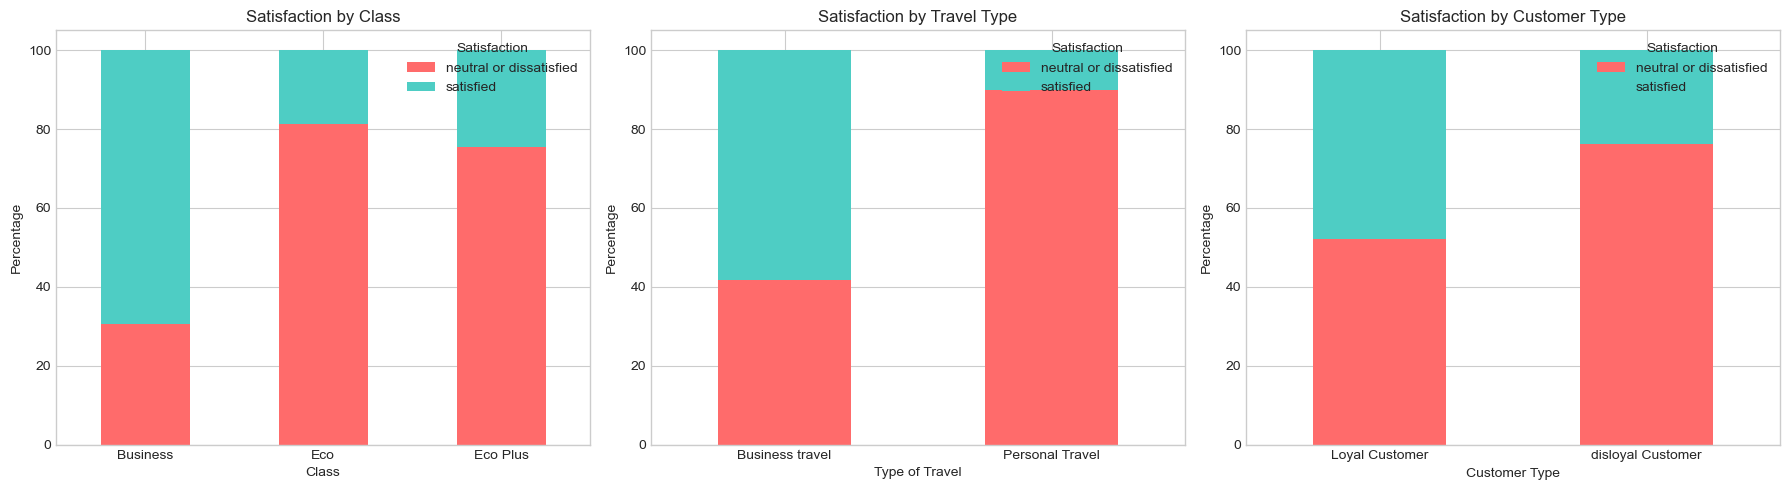

Satisfaction % by Class:
Class
Business    69.4
Eco         18.6
Eco Plus    24.6
Name: satisfied, dtype: float64


In [7]:
def stacked_pct_plot(df, group_col, ax, title):
    grouped = df.groupby([group_col, "satisfaction"]).size().unstack(fill_value=0)
    pct = grouped.div(grouped.sum(axis=1), axis=0) * 100
    pct.plot(kind="bar", stacked=True, ax=ax, color=["#ff6b6b", "#4ecdc4"])
    ax.set_title(title)
    ax.set_ylabel("Percentage")
    ax.legend(title="Satisfaction", loc="upper right")
    ax.tick_params(axis="x", rotation=0)
    return pct

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
pct_class = stacked_pct_plot(train, "Class", axes[0], "Satisfaction by Class")
pct_travel = stacked_pct_plot(train, "Type of Travel", axes[1], "Satisfaction by Travel Type")
pct_customer = stacked_pct_plot(train, "Customer Type", axes[2], "Satisfaction by Customer Type")
plt.tight_layout()
plt.show()

print("Satisfaction % by Class:")
print(pct_class["satisfied"].round(1))

## Section 8: Delay Impact Analysis
Bin departure delays and overlay satisfaction rates with baseline.

C:\Users\Deniz\AppData\Local\Temp\ipykernel_30500\597651455.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  delay_sat = train_delay.groupby(["Delay Category", "satisfaction"]).size().unstack(fill_value=0)


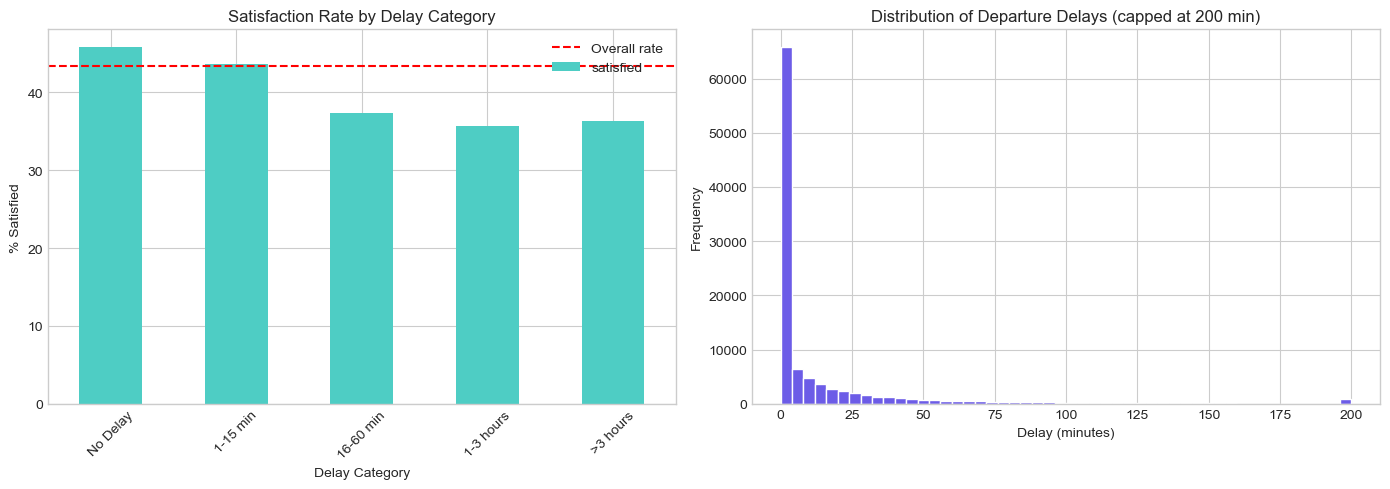

In [8]:
train_delay = train.copy()
train_delay["Delay Category"] = pd.cut(
    train_delay["Departure Delay in Minutes"],
    bins=[-1, 0, 15, 60, 180, float("inf")],
    labels=["No Delay", "1-15 min", "16-60 min", "1-3 hours", ">3 hours"]
)

delay_sat = train_delay.groupby(["Delay Category", "satisfaction"]).size().unstack(fill_value=0)
delay_sat_pct = delay_sat.div(delay_sat.sum(axis=1), axis=0) * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
delay_sat_pct["satisfied"].plot(kind="bar", ax=axes[0], color="#4ecdc4")
axes[0].axhline(y=train["satisfaction"].value_counts(normalize=True)["satisfied"] * 100,
                color="red", linestyle="--", label="Overall rate")
axes[0].set_title("Satisfaction Rate by Delay Category")
axes[0].set_ylabel("% Satisfied")
axes[0].tick_params(axis="x", rotation=45)
axes[0].legend()

train_delay["Departure Delay in Minutes"].clip(upper=200).hist(bins=50, ax=axes[1], color="#6c5ce7", edgecolor="white")
axes[1].set_title("Distribution of Departure Delays (capped at 200 min)")
axes[1].set_xlabel("Delay (minutes)")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

## Section 9: Age & Demographics Analysis
Age distribution by satisfaction and by travel/class segments.

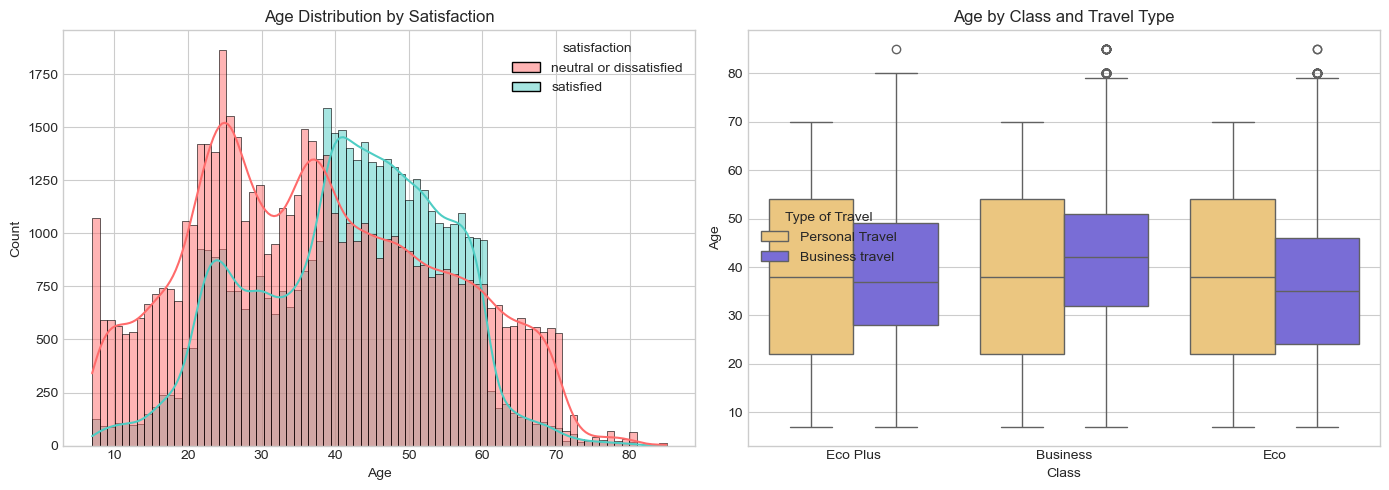

Mean ages by Travel Type and Satisfaction:
Type of Travel   satisfaction           
Business travel  neutral or dissatisfied    36.8
                 satisfied                  42.1
Personal Travel  neutral or dissatisfied    38.3
                 satisfied                  37.9
Name: Age, dtype: float64


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(data=train, x="Age", hue="satisfaction", kde=True, ax=axes[0],
             palette={"satisfied": "#4ecdc4", "neutral or dissatisfied": "#ff6b6b"})
axes[0].set_title("Age Distribution by Satisfaction")

sns.boxplot(data=train, x="Class", y="Age", hue="Type of Travel", ax=axes[1],
            palette={"Business travel": "#6c5ce7", "Personal Travel": "#fdcb6e"})
axes[1].set_title("Age by Class and Travel Type")

plt.tight_layout()
plt.show()

print("Mean ages by Travel Type and Satisfaction:")
print(train.groupby(["Type of Travel", "satisfaction"])["Age"].mean().round(1))

## Section 10: Feature Importance (Correlation & Simple Model)
Use correlation for quick signal and a logistic regression for directional importance.

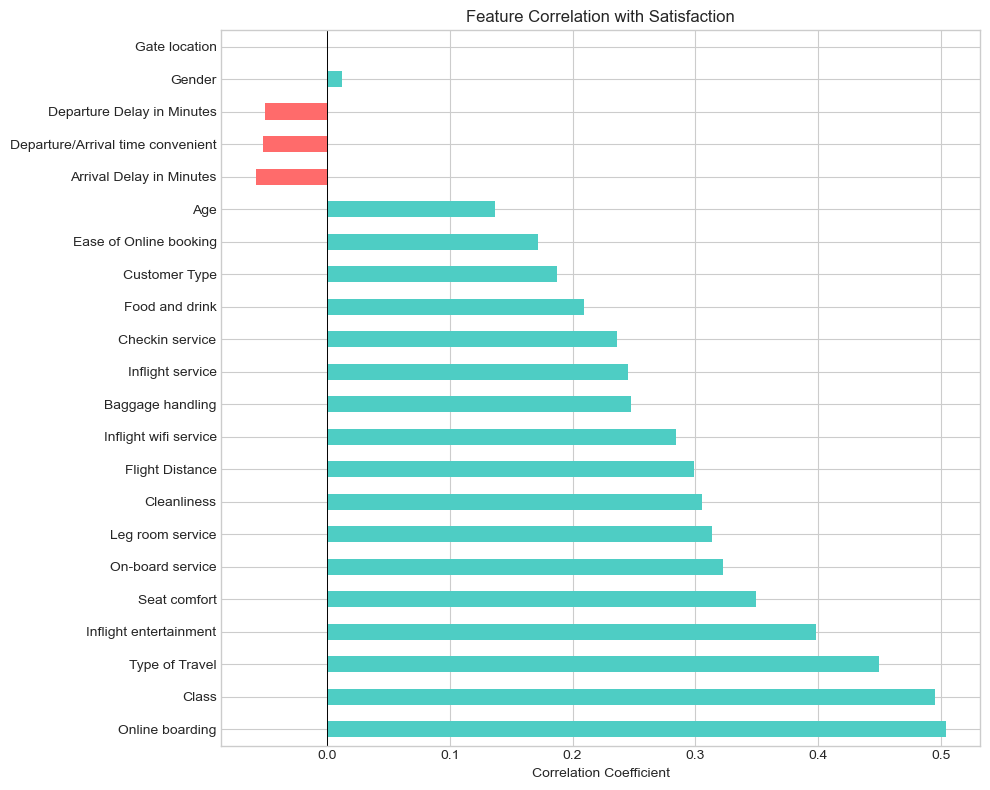

Logistic Regression Validation Accuracy: 0.872
Top coefficients (absolute):
Type of Travel              1.262
Online boarding             0.863
Customer Type               0.776
Inflight wifi service       0.518
Checkin service             0.414
On-board service            0.400
Arrival Delay in Minutes   -0.378
Class                       0.345
Leg room service            0.330
Cleanliness                 0.292
dtype: float64


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Correlation-based importance (already computed)
satisfaction_corr = train_mapped.corr()["satisfaction"].drop("satisfaction").sort_values(key=np.abs, ascending=False)

plt.figure(figsize=(10, 8))
colors = ["#4ecdc4" if v > 0 else "#ff6b6b" for v in satisfaction_corr]
satisfaction_corr.plot(kind="barh", color=colors)
plt.title("Feature Correlation with Satisfaction")
plt.xlabel("Correlation Coefficient")
plt.axvline(x=0, color="black", linewidth=0.7)
plt.tight_layout()
plt.show()

# Simple logistic regression
feature_cols = [c for c in train_mapped.columns if c != "satisfaction"]
X = train_mapped[feature_cols]
y = train_mapped["satisfaction"]

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000))
])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
pipe.fit(X_train, y_train)
valid_score = pipe.score(X_valid, y_valid)
print(f"Logistic Regression Validation Accuracy: {valid_score:.3f}")

coefs = pd.Series(pipe.named_steps["clf"].coef_[0], index=feature_cols).sort_values(key=np.abs, ascending=False)
print("Top coefficients (absolute):")
print(coefs.head(10).round(3))